In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')

In [ ]:
import os

if os.path.exists("data/paysim.csv"):
    df = pd.read_csv("data/paysim.csv")
    total = len(df)
    fraud = df["isFraud"].sum()
else:
    total = 0
    fraud = 0

df = df.sample(n=500000, random_state=42)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
3737323,278,CASH_IN,330218.42,C632336343,20866.00,351084.42,C834976624,452419.57,122201.15,0,0
264914,15,PAYMENT,11647.08,C1264712553,30370.00,18722.92,M215391829,0.00,0.00,0,0
85647,10,CASH_IN,152264.21,C1746846248,106589.00,258853.21,C1607284477,201303.01,49038.80,0,0
5899326,403,TRANSFER,1551760.63,C333676753,0.00,0.00,C1564353608,3198359.45,4750120.08,0,0
2544263,206,CASH_IN,78172.30,C813403091,2921331.58,2999503.88,C1091768874,415821.90,337649.60,0,0


In [3]:
df.shape

(500000, 11)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500000 entries, 3737323 to 3264458
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            500000 non-null  int64  
 1   type            500000 non-null  object 
 2   amount          500000 non-null  float64
 3   nameOrig        500000 non-null  object 
 4   oldbalanceOrg   500000 non-null  float64
 5   newbalanceOrig  500000 non-null  float64
 6   nameDest        500000 non-null  object 
 7   oldbalanceDest  500000 non-null  float64
 8   newbalanceDest  500000 non-null  float64
 9   isFraud         500000 non-null  int64  
 10  isFlaggedFraud  500000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 45.8+ MB


In [5]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,500000.000000,5.000000e+05,5.000000e+05,5.000000e+05,5.000000e+05,5.000000e+05,500000.000000,500000.000000
mean,243.533124,1.806645e+05,8.309977e+05,8.524263e+05,1.106153e+06,1.231487e+06,0.001294,0.000002
std,142.606593,6.053009e+05,2.881332e+06,2.917542e+06,3.373751e+06,3.657557e+06,0.035949,0.001414
min,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,156.000000,1.335691e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,240.000000,7.493207e+04,1.422100e+04,0.000000e+00,1.329772e+05,2.160908e+05,0.000000,0.000000
75%,335.000000,2.092577e+05,1.072500e+05,1.445806e+05,9.534888e+05,1.121774e+06,0.000000,0.000000
max,742.000000,5.365362e+07,3.589244e+07,3.614984e+07,2.754052e+08,3.114049e+08,1.000000,1.000000


In [6]:
df['isFraud'].value_counts()



isFraud
0    499353
1       647
Name: count, dtype: int64

In [7]:
df['isFraud'].value_counts(normalize=True) * 100

isFraud
0    99.8706
1     0.1294
Name: proportion, dtype: float64

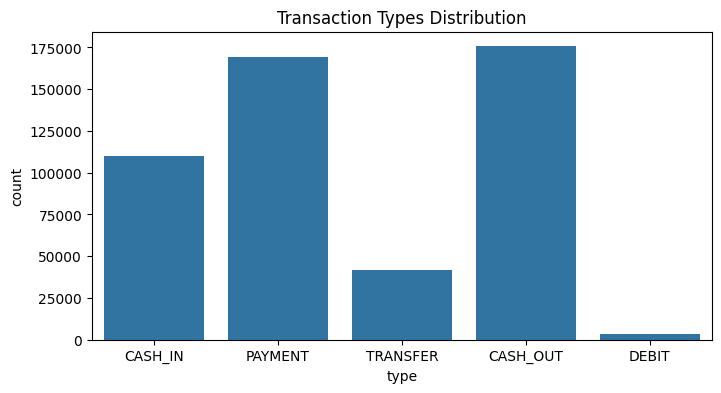

In [8]:
plt.figure(figsize=(8,4))
sns.countplot(x='type', data=df)
plt.title('Transaction Types Distribution')
plt.show()


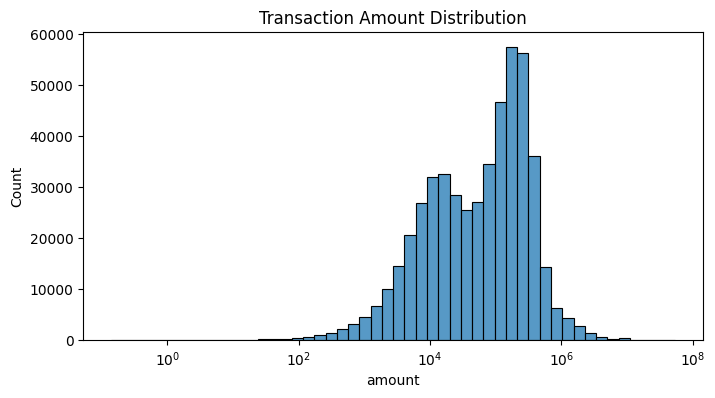

In [9]:
plt.figure(figsize=(8,4))
sns.histplot(df['amount'], bins=50, log_scale=True)
plt.title('Transaction Amount Distribution')
plt.show()


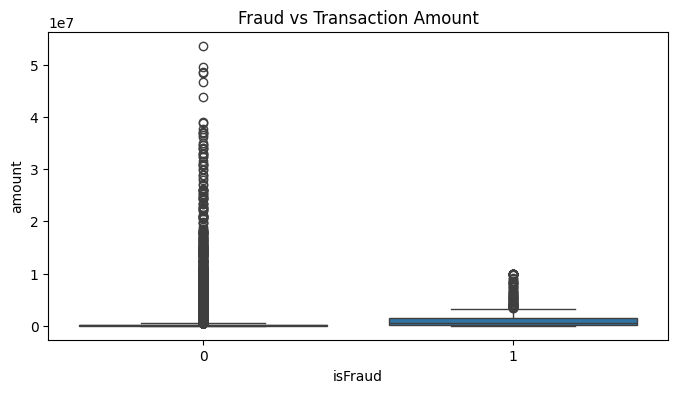

In [10]:

plt.figure(figsize=(8,4))
sns.boxplot(x='isFraud', y='amount', data=df)
plt.title('Fraud vs Transaction Amount')
plt.show()


In [11]:
df = df.drop(columns=['nameOrig', 'nameDest', 'isFlaggedFraud'])


In [12]:
df = pd.get_dummies(df, columns=['type'], drop_first=True)


In [13]:
df.isnull().sum()


step              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
type_CASH_OUT     0
type_DEBIT        0
type_PAYMENT      0
type_TRANSFER     0
dtype: int64

In [14]:
df = df.fillna(0)


In [15]:
df['orig_balance_change'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['dest_balance_change'] = df['newbalanceDest'] - df['oldbalanceDest']


In [16]:
df['amount_to_balance_ratio'] = df['amount'] / (df['oldbalanceOrg'] + 1)


In [17]:
df['balance_mismatch'] = (
    (df['oldbalanceOrg'] - df['amount']) != df['newbalanceOrig']
).astype(int)


In [18]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']


In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)


In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

# Base Logistic Regression
lr_model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

# Calibrated Model
calibrated_model = CalibratedClassifierCV(
    lr_model,
    method='sigmoid',   # safest option
    cv=5
)

# Train calibrated model
calibrated_model.fit(X_train_scaled, y_train)


,"estimator estimator: estimator instance, default=NoneThe classifier whose output need to be calibrated to provide moreaccurate `predict_proba` outputs. The default classifier isa :class:`~sklearn.svm.LinearSVC`... versionadded:: 1.2",LogisticRegre...ndom_state=42)
,"method method: {'sigmoid', 'isotonic', 'temperature'}, default='sigmoid'The method to use for calibration. Can be:- 'sigmoid', which corresponds to Platt's method (i.e. a binary logistic regression model).- 'isotonic', which is a non-parametric approach.- 'temperature', temperature scaling.Sigmoid and isotonic calibration methods natively support only binaryclassifiers and extend to multi-class classification using a One-vs-Rest (OvR)strategy with post-hoc renormalization, i.e., adjusting the probabilities aftercalibration to ensure they sum up to 1.In contrast, temperature scaling naturally supports multi-class calibration byapplying `softmax(classifier_logits/T)` with a value of `T` (temperature)that optimizes the log loss.For very uncalibrated classifiers on very imbalanced datasets, sigmoidcalibration might be preferred because it fits an additional interceptparameter. This helps shift decision boundaries appropriately when theclassifier being calibrated is biased towards the majority class.Isotonic calibration is not recommended when the number of calibration samplesis too low ``(≪1000)`` since it then tends to overfit... versionchanged:: 1.8 Added option 'temperature'.",'sigmoid'
,"cv cv: int, cross-validation generator, or iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross-validation,- integer, to specify the number of folds.- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if ``y`` is binary or multiclass,:class:`~sklearn.model_selection.StratifiedKFold` is used. If ``y`` isneither binary nor multiclass, :class:`~sklearn.model_selection.KFold`is used.Refer to the :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors.Base estimator clones are fitted in parallel across cross-validationiterations.See :term:`Glossary ` for more details... versionadded:: 0.24",None
,"ensemble ensemble: bool, or ""auto"", default=""auto""Determines how the calibrator is fitted.""auto"" will use `False` if the `estimator` is a:class:`~sklearn.frozen.FrozenEstimator`, and `True` otherwise.If `True`, the `estimator` is fitted using training data, andcalibrated using testing data, for each `cv` fold. The final estimatoris an ensemble of `n_cv` fitted classifier and calibrator pairs, where`n_cv` is the number of cross-validation folds. The output is theaverage predicted probabilities of all pairs.If `False`, `cv` is used to compute unbiased predictions, via:func:`~sklearn.model_selection.cross_val_predict`, which are thenused for calibration. At prediction time, the classifier used is the`estimator` trained on all the data.Note that this method is also internally implemented in:mod:`sklearn.svm` estimators with the `probabilities=True` parameter... versionadded:: 0.24.. versionchanged:: 1.6 `""auto""` option is added and is the default.",'auto'
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprec

In [22]:
y_pred = calibrated_model.predict(X_test_scaled)
y_prob = calibrated_model.predict_proba(X_test_scaled)[:, 1]


In [23]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score
)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


[[149800      6]
 [    89    105]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    149806
           1       0.95      0.54      0.69       194

    accuracy                           1.00    150000
   macro avg       0.97      0.77      0.84    150000
weighted avg       1.00      1.00      1.00    150000

ROC-AUC: 0.9991138023045889


In [24]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)



,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",12
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

In [25]:
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))



[[149806      0]
 [     1    193]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    149806
           1       1.00      0.99      1.00       194

    accuracy                           1.00    150000
   macro avg       1.00      1.00      1.00    150000
weighted avg       1.00      1.00      1.00    150000

ROC-AUC: 1.0


In [26]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train, y_train)


,"objective objective: str | xgboost.sklearn._SklObjWProto | typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]] | NoneSpecify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: float | typing.List[float] | NoneThe initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.List[xgboost.callback.TrainingCallback] | NoneList of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: float | NoneSubsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: float | NoneSubsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: float | NoneSubsample ratio of columns when constructing each tree.,0.8
,"device device: str | None.. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: int | None.. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: str | typing.List[str | typing.Callable] | typing.Callable | None.. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes from sklearn.metrics import mean_absolute_error X, y = load_diabetes(return_X_y=True) reg = xgb.XGBRegressor( tree_metho

In [27]:
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))


[[149804      2]
 [     0    194]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    149806
           1       0.99      1.00      0.99       194

    accuracy                           1.00    150000
   macro avg       0.99      1.00      1.00    150000
weighted avg       1.00      1.00      1.00    150000

ROC-AUC: 0.9999995870948419


In [28]:
importances = xgb_model.feature_importances_
features = X.columns

fi = pd.Series(importances, index=features).sort_values(ascending=False)

fi.head(10)


balance_mismatch           0.587000
orig_balance_change        0.157858
newbalanceOrig             0.119341
amount_to_balance_ratio    0.076824
amount                     0.013590
type_TRANSFER              0.013419
type_CASH_OUT              0.009363
dest_balance_change        0.006187
step                       0.005657
newbalanceDest             0.004383
dtype: float32

In [29]:
# Fraud probability from XGBoost
fraud_prob = xgb_model.predict_proba(X_test)[:, 1]

# Convert probability to risk score (0–100)
risk_score = (fraud_prob * 100).round(2)


In [30]:
def risk_category(score):
    if score >= 70:
        return 'High Risk'
    elif score >= 30:
        return 'Medium Risk'
    else:
        return 'Low Risk'


In [31]:
risk_labels = pd.Series(risk_score).apply(risk_category)

In [32]:
risk_df = X_test.copy()
risk_df['Actual_Fraud'] = y_test.values
risk_df['Risk_Score'] = risk_score
risk_df['Risk_Level'] = risk_labels

risk_df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,orig_balance_change,dest_balance_change,amount_to_balance_ratio,balance_mismatch,Actual_Fraud,Risk_Score,Risk_Level
4574198,328,376602.50,2576359.28,2952961.78,534501.50,157899.00,False,False,False,False,-376602.50,-376602.50,0.146176,1,0,0.0,NaN
2711099,211,204380.22,0.00,0.00,3223085.77,3427465.99,True,False,False,False,0.00,204380.22,204380.220000,1,0,0.0,NaN
3206315,249,66635.60,545242.97,611878.58,934854.40,868218.79,False,False,False,False,-66635.61,-66635.61,0.122212,1,0,0.0,NaN
3707095,277,255745.64,0.00,0.00,3946571.40,4202317.04,False,False,False,True,0.00,255745.64,255745.640000,1,0,0.0,NaN
2776216,214,155033.51,144.00,0.00,2954.01,157987.52,True,False,False,False,144.00,155033.51,1069.196621,1,0,0.0,NaN


In [33]:
# Always pick the most suspicious transaction
high_risk_index = risk_df['Risk_Score'].idxmax()

print("Max Risk Score:", risk_df.loc[high_risk_index, 'Risk_Score'])


Max Risk Score: 100.0


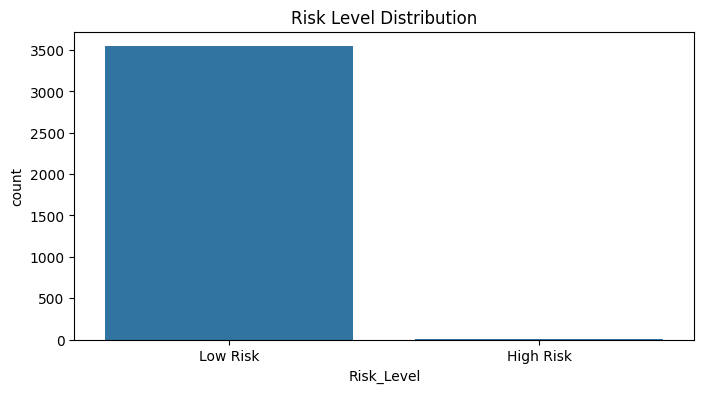

In [34]:
plt.figure(figsize=(8,4))
sns.countplot(x='Risk_Level', data=risk_df)
plt.title('Risk Level Distribution')
plt.show()


In [35]:
high_risk_alerts = risk_df[risk_df['Risk_Level'] == 'High Risk']

print("High Risk Transactions:", len(high_risk_alerts))


High Risk Transactions: 9


In [36]:
high_risk_fraud_recall = (
    high_risk_alerts['Actual_Fraud'].sum() / y_test.sum()
)

print("High Risk Fraud Recall:", high_risk_fraud_recall)


High Risk Fraud Recall: 0.0


In [37]:
import shap

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)


C:\Users\Padmanabh\AppData\Roaming\Python\Python314\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


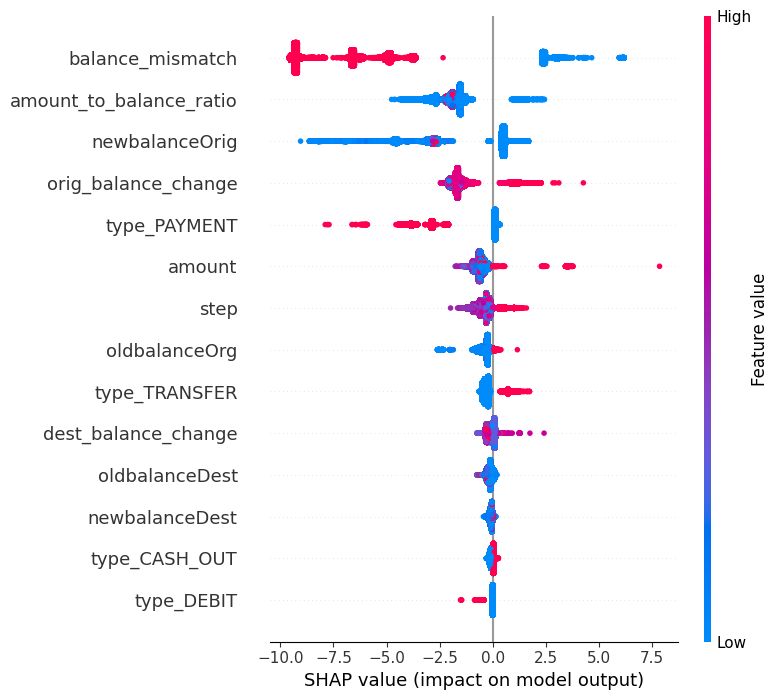

In [38]:
shap.summary_plot(shap_values, X_test)


In [39]:
risk_df['Risk_Level'].value_counts()



Risk_Level
Low Risk     3546
High Risk       9
Name: count, dtype: int64

In [40]:
high_risk_rows = risk_df[risk_df['Risk_Level'] == 'High Risk']

if not high_risk_rows.empty:
    high_risk_index = high_risk_rows.index[0]
    print("High Risk index:", high_risk_index)
else:
    print("No High Risk transactions found")



High Risk index: 38211


In [41]:
if high_risk_index in X_test.index:
    row_position = X_test.index.get_loc(high_risk_index)
else:
    raise ValueError("High-risk transaction not found in X_test")


In [42]:
risk_df['Top_Reason'] = 'Normal'

risk_df.loc[
    risk_df['Risk_Level'] == 'High Risk',
    'Top_Reason'
] = 'High amount + balance mismatch'



In [46]:
print("Model trained successfully")
print(type(xgb_model))

Model trained successfully
<class 'xgboost.sklearn.XGBClassifier'>


In [44]:
import joblib
import shap

explainer = shap.TreeExplainer(xgb_model)

joblib.dump(explainer, '../app/shap_explainer.pkl')


['../app/shap_explainer.pkl']

In [47]:
import os
import pickle
import shap

# Ensure app folder exists
os.makedirs("../app", exist_ok=True)

# ================= SAVE MODEL =================
with open("../app/model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)   # or calibrated_model

# ================= SAVE SCALER =================
with open("../app/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

# ================= SAVE FEATURES =================
with open("../app/features.pkl", "wb") as f:
    pickle.dump(list(X_train.columns), f)

# ================= SAVE SHAP EXPLAINER =================
explainer = shap.TreeExplainer(xgb_model)

with open("../app/shap_explainer.pkl", "wb") as f:
    pickle.dump(explainer, f)

print("✅ Model, scaler, features, SHAP saved successfully!")


✅ Model, scaler, features, SHAP saved successfully!
